In [1]:
import cv2
import os
import subprocess
import mediapipe as mp
import csv
import numpy as np
import plotly.graph_objects as go

# 동영상 프레임 확인

In [2]:
# 비디오 파일 경로 목록
video_paths = [
    "~/Documents/ds_study/mlb pitcher/pitcher/Brash.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Burns.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Cole.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Helsely.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Holmes.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/May.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Ohtani.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Ryan.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Strider.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Stroman.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Verlander.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/amatuer.mp4"
]

# 프레임레이트를 확인하는 함수
def check_frame_rates(video_paths):
    for video_path in video_paths:
        abs_video_path = os.path.expanduser(video_path)
        cap = cv2.VideoCapture(abs_video_path)
        if not cap.isOpened():
            print(f"Error opening video file: {abs_video_path}")
            continue
        fps = cap.get(cv2.CAP_PROP_FPS)
        print(f"Frame rate of {os.path.basename(video_path)}: {fps} FPS")
        cap.release()


# 비디오 파일의 프레임레이트 확인 실행
check_frame_rates(video_paths)

Frame rate of Brash.mp4: 30.0 FPS
Frame rate of Burns.mp4: 30.0 FPS
Frame rate of Cole.mp4: 30.0 FPS
Frame rate of Helsely.mp4: 29.97 FPS
Frame rate of Holmes.mp4: 30.0 FPS
Frame rate of May.mp4: 30.0 FPS
Frame rate of Ohtani.mp4: 29.97 FPS
Frame rate of Ryan.mp4: 30.0 FPS
Frame rate of Strider.mp4: 30.0 FPS
Frame rate of Stroman.mp4: 30.0 FPS
Frame rate of Verlander.mp4: 30.0 FPS
Frame rate of amatuer.mp4: 30.0 FPS


# 비디오 데이터 로드 및 프레임 추출

In [3]:
# 주어진 시간 범위 내에서 비디오 데이터를 추출하는 함수
def extract_video_data(video_path, start_time, end_time):
    video_path = os.path.expanduser(video_path)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"비디오 파일을 열 수 없습니다: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS)
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    extracted_frames = []
    frame_idx = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if start_frame <= frame_idx <= end_frame:
            extracted_frames.append(frame)
        frame_idx += 1
    cap.release()
    return extracted_frames


# 관절 위치 추출

In [4]:
# 프레임에서 관절 위치를 추출하는 함수
def extract_joint_positions(frames):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
    pitcher_poses = []
    correction_points = [11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]
    for frame in frames:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)
        if results.pose_landmarks:
            
            pose_data = [(results.pose_landmarks.landmark[point].x,
                          results.pose_landmarks.landmark[point].y) for point in correction_points]
            pitcher_poses.append(pose_data)
    pose.close()
    return pitcher_poses


# 데이터 저장 및 정규화

In [5]:
# 추출된 관절 위치 데이터를 CSV 파일로 저장하는 함수
def save_to_csv(data, csv_filename):
    csv_filename = os.path.expanduser(csv_filename)
    os.makedirs(os.path.dirname(csv_filename), exist_ok=True)
    with open(csv_filename, 'w', newline='') as file:
        writer = csv.writer(file)
        for pose in data:
            flattened_pose = [val for sublist in pose for val in sublist]
            writer.writerow(flattened_pose)

# 데이터 로드 및 정규화

In [6]:
# CSV 파일로부터 데이터를 로드하고 정규화하는 함수
def load_data_from_csv(csv_filename):
    csv_filename = os.path.expanduser(csv_filename)
    return np.loadtxt(csv_filename, delimiter=',')

def normalize_data(data):
    mean = np.mean(data, axis=0)
    
    std = np.std(data, axis=0)
    normalized = (data - mean) / std
    return normalized


# 분석 결과 저장

In [7]:
# 데이터를 분석하고 결과를 파일로 저장하는 함수
def analyze_data(data):
    return np.mean(data, axis=0)

def save_analysis_result(result, filename):
    filename = os.path.expanduser(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'w') as file:
        file.write(','.join(map(str, result)))


In [8]:
def analyze_data(data):
    # 데이터 분석 로직 구현, 예: 평균 계산
    return np.mean(data, axis=0)
def save_analysis_result(result, filename):
    # 분석 결과를 파일로 저장하는 로직 구현
    filename = os.path.expanduser(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'w') as file:
        file.write(','.join(map(str, result)))

# 인수 설정

In [9]:
import os
import numpy as np

def analyze_pitcher_video(video_path, start_time, end_time, csv_filename, analysis_result_filename):
    # 비디오에서 프레임 추출
    extracted_frames = extract_video_data(video_path, start_time, end_time)
    # 프레임에서 관절 위치 추출
    pitcher_poses = extract_joint_positions(extracted_frames)
    # 관절 위치 데이터를 CSV 파일로 저장
    save_to_csv(pitcher_poses, csv_filename)
    # CSV 파일로부터 데이터 로드
    data = np.loadtxt(csv_filename, delimiter=',')

# 비디오 파일 경로 설정
video_paths = [
    "~/Documents/ds_study/mlb pitcher/pitcher/Brash.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Burns.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Cole.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Helsely.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Holmes.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/May.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Ohtani.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Ryan.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Strider.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Stroman.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/Verlander.mp4",
    "~/Documents/ds_study/mlb pitcher/pitcher/amatuer.mp4"
]

# 비디오 파일의 프레임레이트 확인 및 분석 실행
check_frame_rates(video_paths)  # 프레임레이트 확인

start_times = [0.2] * len(video_paths)
end_times = [1.55] * len(video_paths)
csv_filenames = [os.path.expanduser(f"~/Documents/ds_study/mlb pitcher/{os.path.splitext(os.path.basename(path))[0]}.csv") for path in video_paths]
analysis_result_filenames = [os.path.expanduser(f"~/Documents/ds_study/mlb pitcher/{os.path.splitext(os.path.basename(path))[0]}_analysis.csv") for path in video_paths]

# 각 비디오에 대해 분석 수행
for video_path, start_time, end_time, csv_filename, analysis_result_filename in zip(video_paths, start_times, end_times, csv_filenames, analysis_result_filenames):
    analyze_pitcher_video(video_path, start_time, end_time, csv_filename, analysis_result_filename)

Frame rate of Brash.mp4: 30.0 FPS
Frame rate of Burns.mp4: 30.0 FPS
Frame rate of Cole.mp4: 30.0 FPS
Frame rate of Helsely.mp4: 29.97 FPS
Frame rate of Holmes.mp4: 30.0 FPS
Frame rate of May.mp4: 30.0 FPS
Frame rate of Ohtani.mp4: 29.97 FPS
Frame rate of Ryan.mp4: 30.0 FPS
Frame rate of Strider.mp4: 30.0 FPS
Frame rate of Stroman.mp4: 30.0 FPS
Frame rate of Verlander.mp4: 30.0 FPS
Frame rate of amatuer.mp4: 30.0 FPS
분석이 완료되어 C:\Users\VICTUS/Documents/ds_study/mlb pitcher/Brash_analysis.csv에 저장되었습니다.
분석이 완료되어 C:\Users\VICTUS/Documents/ds_study/mlb pitcher/Burns_analysis.csv에 저장되었습니다.
분석이 완료되어 C:\Users\VICTUS/Documents/ds_study/mlb pitcher/Cole_analysis.csv에 저장되었습니다.
분석이 완료되어 C:\Users\VICTUS/Documents/ds_study/mlb pitcher/Helsely_analysis.csv에 저장되었습니다.
분석이 완료되어 C:\Users\VICTUS/Documents/ds_study/mlb pitcher/Holmes_analysis.csv에 저장되었습니다.
분석이 완료되어 C:\Users\VICTUS/Documents/ds_study/mlb pitcher/May_analysis.csv에 저장되었습니다.
분석이 완료되어 C:\Users\VICTUS/Documents/ds_study/mlb pitcher/Ohtani_analysi

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
from tensorflow.keras.layers import TimeDistributed

pro_pitcher_files = [
    '~/Documents/ds_study/mlb pitcher/Brash.csv',
    '~/Documents/ds_study/mlb pitcher/Burns.csv',
    '~/Documents/ds_study/mlb pitcher/Cole.csv',
    '~/Documents/ds_study/mlb pitcher/Helsely.csv',
    '~/Documents/ds_study/mlb pitcher/Holmes.csv',
    '~/Documents/ds_study/mlb pitcher/May.csv',
    '~/Documents/ds_study/mlb pitcher/Ohtani.csv',
    '~/Documents/ds_study/mlb pitcher/Ryan.csv',
    '~/Documents/ds_study/mlb pitcher/Strider.csv',
    '~/Documents/ds_study/mlb pitcher/Stroman.csv',
    '~/Documents/ds_study/mlb pitcher/Verlander.csv'
]

# 아마추어 투수 데이터 파일 경로
amateur_pitcher_file = ['~/Documents/ds_study/mlb pitcher/amatuer.csv'] 

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

# 데이터 로드 및 전처리 함수
def load_data(filenames):
    all_data = []
    for filename in filenames:
        # 파일 경로 확장 및 데이터 로드
        expanded_filename = os.path.expanduser(filename)
        data = np.loadtxt(expanded_filename, delimiter=',')
        all_data.append(data)
    return all_data

def preprocess_data(all_data, scaler=None, maxlen=100):
    scaled_and_padded_data = []
    for data in all_data:
        if scaler is None:
            scaler = StandardScaler().fit(data)
        data_normalized = scaler.transform(data)
        data_padded = pad_sequences(data_normalized[np.newaxis, :, :], maxlen=maxlen, dtype='float32', padding='post')
        scaled_and_padded_data.append(data_padded.squeeze(0))
    return np.stack(scaled_and_padded_data), scaler

# 모델 구축 함수
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32, return_sequences=True),
        TimeDistributed(Dense(32, activation='relu')),
        TimeDistributed(Dense(input_shape[-1]))
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 프로 투수 데이터 파일 경로
pro_pitcher_files = [
    '~/Documents/ds_study/mlb pitcher/Brash.csv',
    '~/Documents/ds_study/mlb pitcher/Burns.csv',
    '~/Documents/ds_study/mlb pitcher/Cole.csv',
    '~/Documents/ds_study/mlb pitcher/Helsely.csv',
    '~/Documents/ds_study/mlb pitcher/Holmes.csv',
    '~/Documents/ds_study/mlb pitcher/May.csv',
    '~/Documents/ds_study/mlb pitcher/Ohtani.csv',
    '~/Documents/ds_study/mlb pitcher/Ryan.csv',
    '~/Documents/ds_study/mlb pitcher/Strider.csv',
    '~/Documents/ds_study/mlb pitcher/Stroman.csv',
    '~/Documents/ds_study/mlb pitcher/Verlander.csv'
]

amateur_pitcher_file = '~/Documents/ds_study/mlb pitcher/amatuer.csv'  # 아마추어 투수 파일 경로

pro_pitcher_data, scaler = preprocess_data(load_data(pro_pitcher_files))
amateur_data, _ = preprocess_data(load_data([amateur_pitcher_file]), scaler)

# "이상적인 투수" 데이터 생성
ideal_data = np.mean(pro_pitcher_data, axis=0)

# 모델 구축 및 학습 준비
num_features = pro_pitcher_data.shape[2]  # 특성 수 설정
max_sequence_length = pro_pitcher_data.shape[1]  # 시퀀스 길이 설정
model = build_lstm_model((max_sequence_length, num_features))

Y_train = np.repeat(ideal_data[np.newaxis, :, :], pro_pitcher_data.shape[0], axis=0)

# 모델 학습
model.fit(pro_pitcher_data, Y_train, epochs=20, batch_size=32, validation_split=0.2)

# 아마추어 투수 데이터 예측
predicted_motion = model.predict(amateur_data)





Epoch 1/20

1/1 [==============================] - 5s 5s/step - loss: 0.6862 - val_loss: 0.6704
Epoch 2/20
1/1 [==============================] - 0s 50ms/step - loss: 0.6705 - val_loss: 0.6595
Epoch 3/20
1/1 [==============================] - 0s 49ms/step - loss: 0.6580 - val_loss: 0.6480
Epoch 4/20
1/1 [==============================] - 0s 50ms/step - loss: 0.6457 - val_loss: 0.6346
Epoch 5/20
1/1 [==============================] - 0s 50ms/step - loss: 0.6319 - val_loss: 0.6181
Epoch 6/20
1/1 [==============================] - 0s 49ms/step - loss: 0.6165 - val_loss: 0.5998
Epoch 7/20
1/1 [==============================] - 0s 52ms/step - loss: 0.6003 - val_loss: 0.5816
Epoch 8/20
1/1 [==============================] - 0s 59ms/step - loss: 0.5848 - val_loss: 0.5643
Epoch 9/20
1/1 [==============================] - 0s 52ms/step - loss: 0.5702 - val_loss: 0.5479
Epoch 10/20
1/1 [==============================] - 0s 56ms/step - loss: 0.5560 - val_loss: 0.5322
Epoch 11/20
1/1 [===========

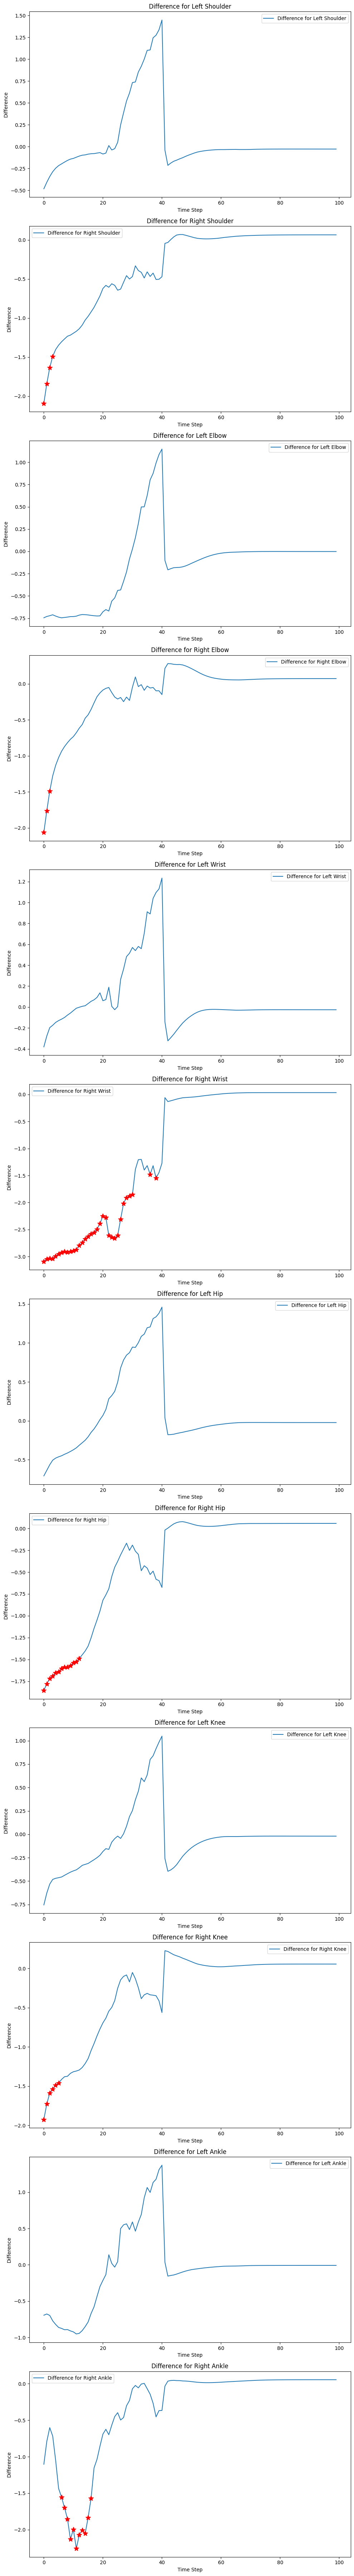

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 이상적인 투수 데이터와 아마추어 투수 데이터 간의 차이 계산
difference = ideal_data - predicted_motion.squeeze(0)

# 임계값 설정
threshold = np.percentile(np.abs(difference), 95)

# 설정된 관절 포인트 및 이름 매핑
correction_points = {
    11: "Left Shoulder",
    12: "Right Shoulder",
    13: "Left Elbow",
    14: "Right Elbow",
    15: "Left Wrist",
    16: "Right Wrist",
    23: "Left Hip",
    24: "Right Hip",
    25: "Left Knee",
    26: "Right Knee",
    27: "Left Ankle",
    28: "Right Ankle"
}

# 차이 데이터의 차원을 확인하고, 이에 맞게 관절 포인트 인덱스를 조정
adjusted_correction_points = [i-11 for i in correction_points if i-11 < difference.shape[1]]

fig, axs = plt.subplots(len(adjusted_correction_points), 1, figsize=(10, 6*len(adjusted_correction_points)))

for i, point in enumerate(adjusted_correction_points):
    # 실제 관절 이름으로 레이블 지정
    joint_name = list(correction_points.values())[i]
    point_difference = difference[:, point]
    
    axs[i].plot(point_difference, label=f'Difference for {joint_name}')
    significant_indices = np.where(np.abs(point_difference) > threshold)[0]
    for index in significant_indices:
        axs[i].plot(index, point_difference[index], 'r*', markersize=10)
    
    axs[i].set_title(f"Difference for {joint_name}")
    axs[i].set_xlabel("Time Step")
    axs[i].set_ylabel("Difference")
    axs[i].legend()

plt.tight_layout()
plt.show()


In [4]:
import cv2
import numpy as np
import pandas as pd

# 이상적인 투수의 관절 위치 데이터 로드
ideal_pitcher_data_path = '~/Documents/ds_study/mlb pitcher/ideal_pitcher_data.csv'
ideal_pitcher_data = pd.read_csv(ideal_pitcher_data_path)

# 아마추어 투수 영상 로드 및 해상도 확인
video_path = 'Documents/ds_study/mlb pitcher/pitcher/amatuer.mp4'  # 아마추어 투수 영상 경로
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    print("Failed to get the first frame of the video")
    cap.release()
    exit()

video_height, video_width = frame.shape[:2]
cap.release()  # 영상 로드 완료 후, 캡처 객체 해제

# 데이터 전처리: 정규화된 좌표를 실제 영상의 해상도에 맞게 조정
joint_positions = ideal_pitcher_data.values  # 정규화된 좌표 (0~1 사이 값)
adjusted_joint_positions = []

for pos in joint_positions:
    # (x, y) 좌표를 영상의 해상도에 맞게 스케일링
    x, y = pos
    adjusted_x = int(x * video_width)
    adjusted_y = int(y * video_height)
    adjusted_joint_positions.append((adjusted_x, adjusted_y))



Failed to get the first frame of the video


AttributeError: 'NoneType' object has no attribute 'shape'

# 속도와 가속도 비교 시각화

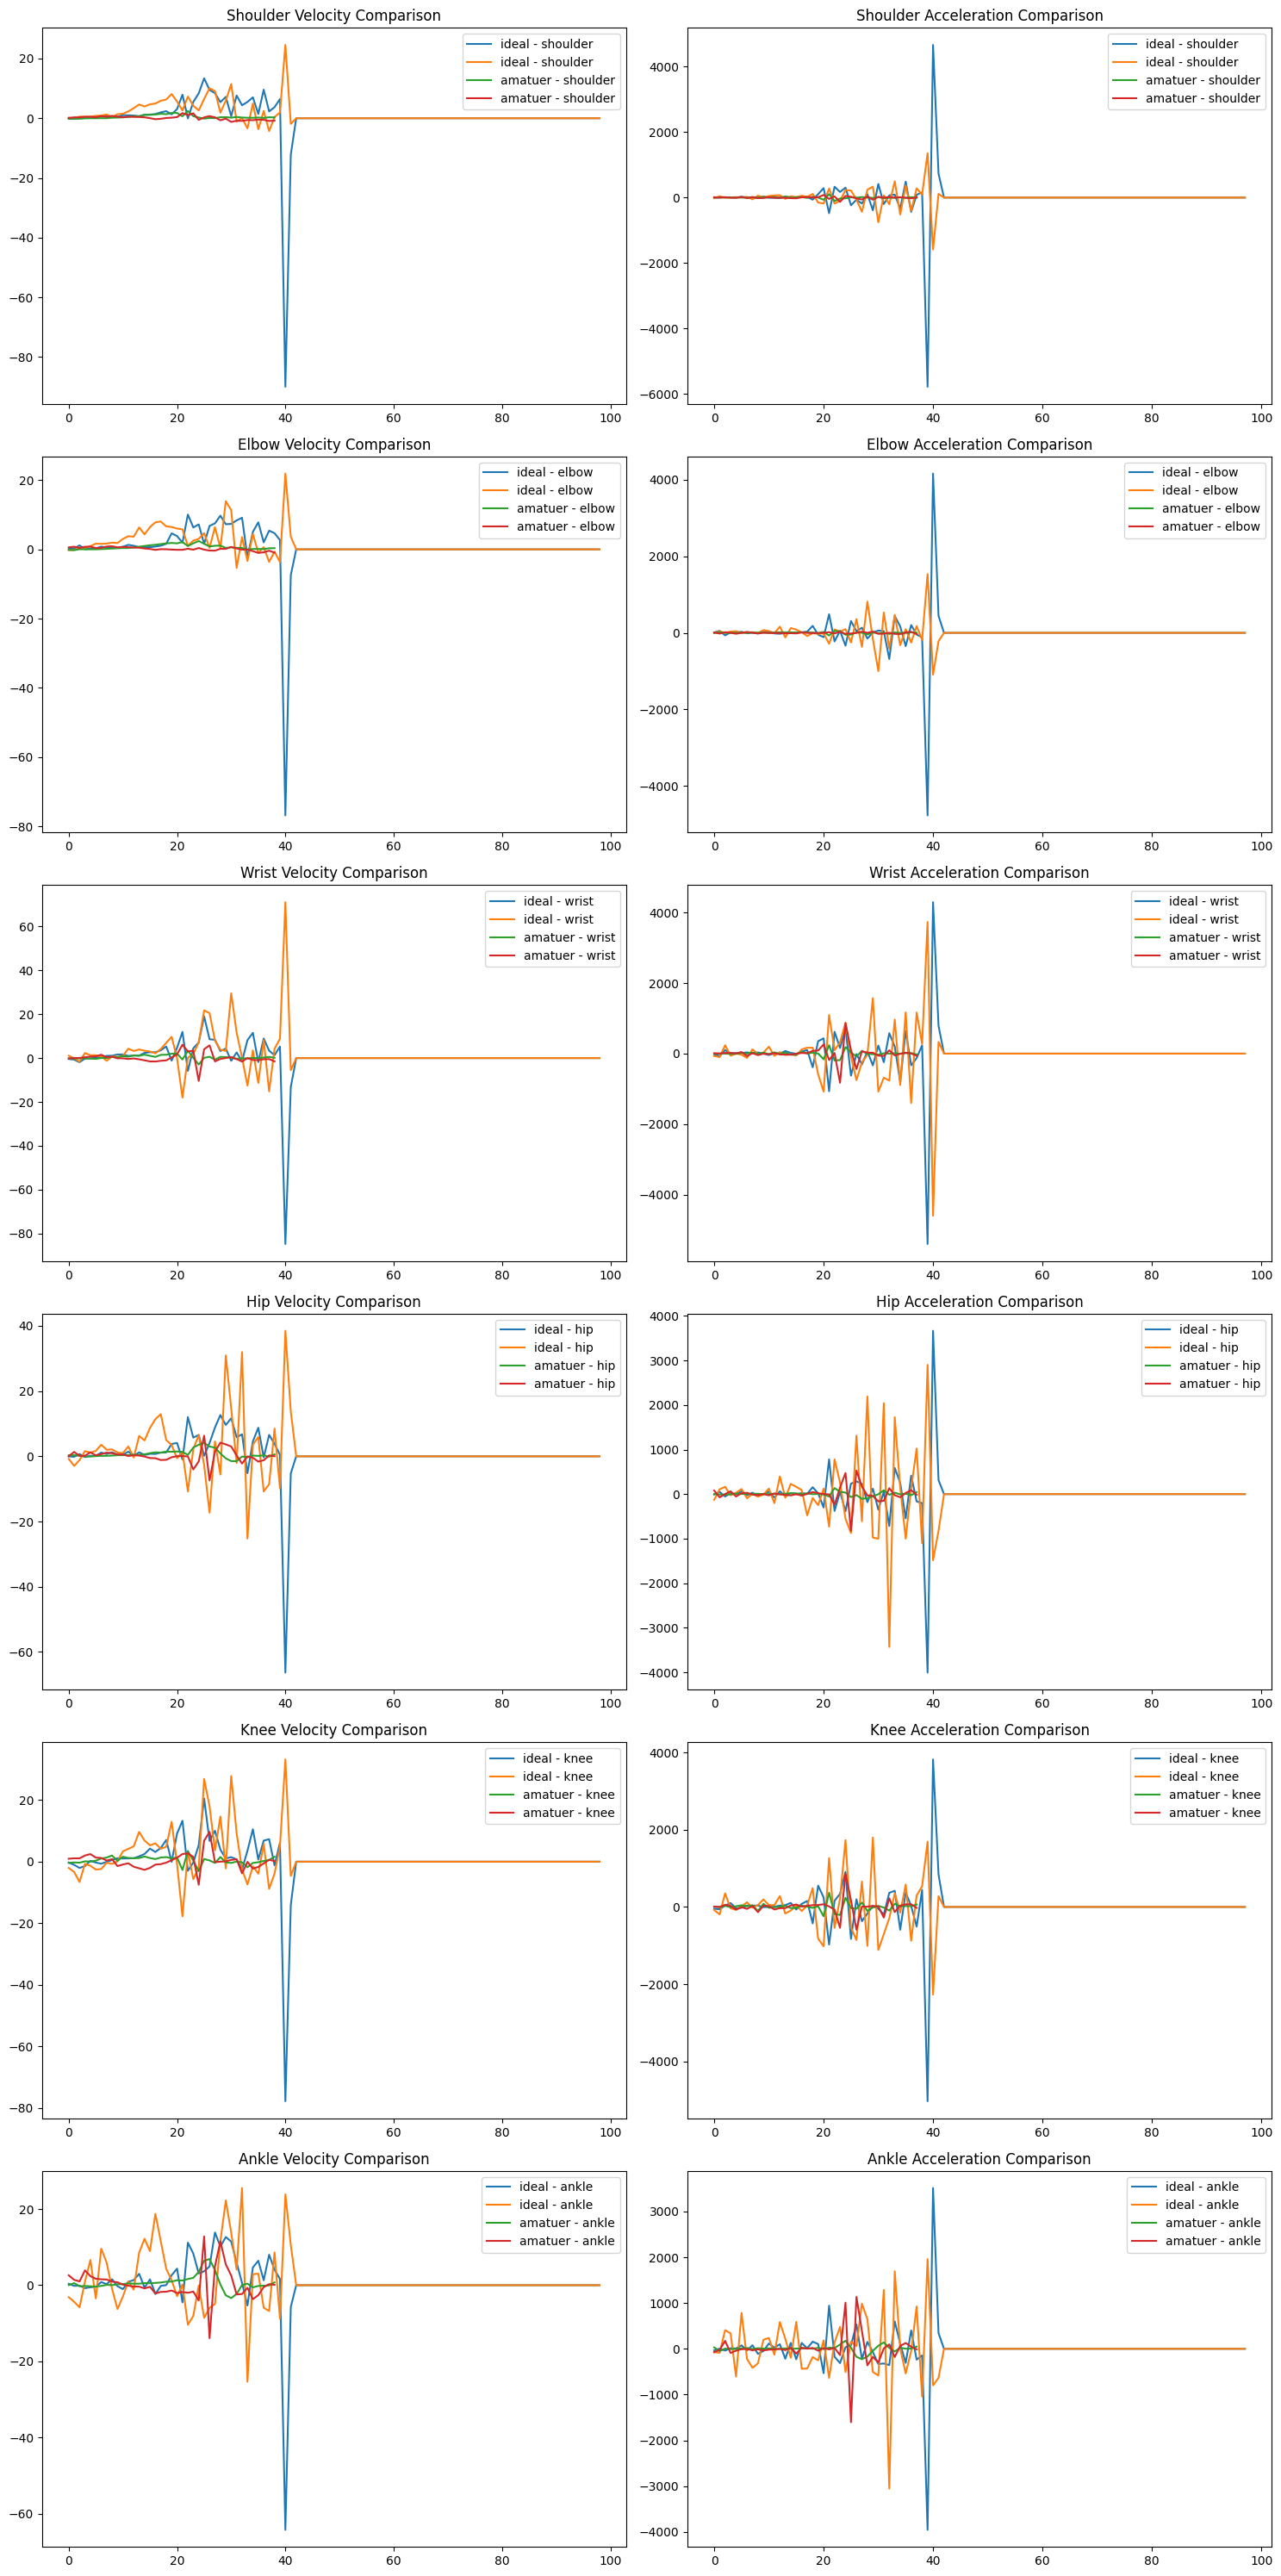

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 투수별 관절 위치 데이터 파일 경로 설정
pitcher_files = {
    'ideal': os.path.expanduser("~/Documents/ds_study/mlb pitcher/ideal_pitcher_data.csv"),
    'amatuer': os.path.expanduser("~/Documents/ds_study/mlb pitcher/amatuer.csv"),
}

# fps 설정
fps = 60

# 관절 인덱스 설정
joint_indices = {
    'shoulder': [0, 1],
    'elbow': [2, 3],
    'wrist': [4, 5],
    'hip': [6, 7],
    'knee': [8, 9],
    'ankle': [10, 11],
}

# 속도 계산 함수
def calculate_velocity(data, fps):
    # 데이터에서 속도 계산 (차분을 이용)
    velocity = np.diff(data, axis=0) * fps
    return velocity

# 가속도 계산 함수
def calculate_acceleration(velocity, fps):
    # 속도 데이터에서 가속도 계산 (차분을 이용)
    acceleration = np.diff(velocity, axis=0) * fps
    return acceleration

# 관절 속도와 가속도를 시각화하는 함수
def visualize_joint_kinetics_comparison(pitcher_files, joint_indices, fps):
    fig, axes = plt.subplots(nrows=len(joint_indices), ncols=2, figsize=(15, len(joint_indices) * 5))
    
    # 두 투수의 데이터 로드 및 계산
    pitcher_data = {}
    for pitcher_name, filepath in pitcher_files.items():
        data = np.loadtxt(filepath, delimiter=',', skiprows=1)
        pitcher_data[pitcher_name] = {}
        
        for joint_name, indices in joint_indices.items():
            joint_data = data[:, indices]
            velocity = calculate_velocity(joint_data, fps)
            acceleration = calculate_acceleration(velocity, fps)
            
            pitcher_data[pitcher_name][joint_name] = {
                'position': joint_data,
                'velocity': velocity,
                'acceleration': acceleration
            }
    
    # 각 관절 별로 두 투수의 속도와 가속도 비교
    for i, joint_name in enumerate(joint_indices.keys()):
        for j, measure in enumerate(['velocity', 'acceleration']):
            ax = axes[i, j]
            for pitcher_name, data in pitcher_data.items():
                joint_data = data[joint_name][measure]
                
                if joint_data.size > 0:  # 데이터가 존재하는 경우에만 플롯
                    ax.plot(joint_data, label=f'{pitcher_name} - {joint_name}')
            
            ax.set_title(f'{joint_name.capitalize()} {measure.capitalize()} Comparison')
            ax.legend()
    
    plt.tight_layout()
    plt.show()

# 관절 속도와 가속도 비교 시각화 실행
visualize_joint_kinetics_comparison(pitcher_files, joint_indices, fps)

# 관절의 최대/최소 위치 시각화

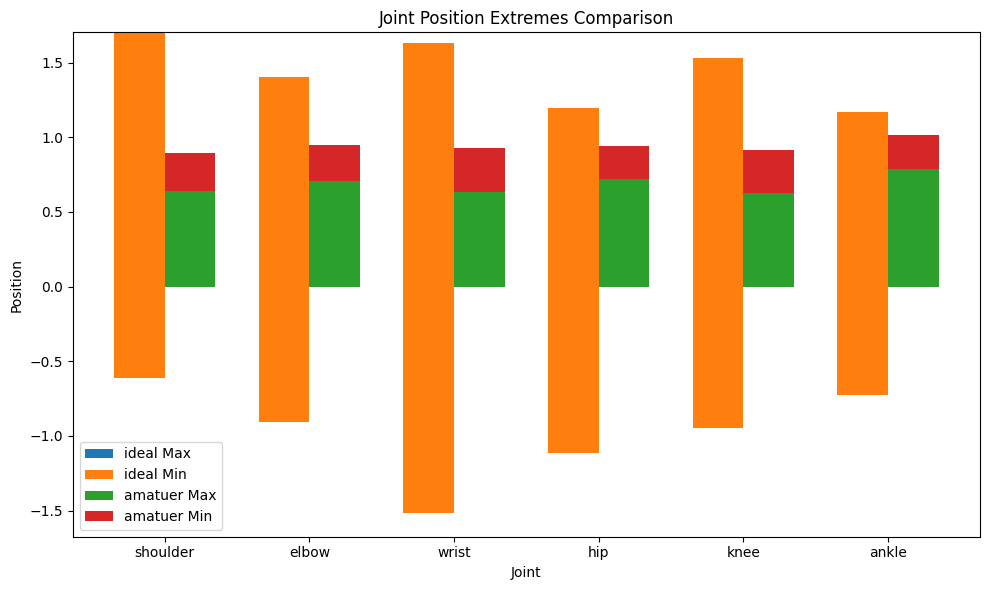

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 투수별 관절 위치 데이터 파일 경로 설정
pitcher_files = {
    'ideal': os.path.expanduser("~/Documents/ds_study/mlb pitcher/ideal_pitcher_data.csv"),
    'amatuer': os.path.expanduser("~/Documents/ds_study/mlb pitcher/amatuer.csv"),
}

# 관절 인덱스 설정
joint_indices = {
    'shoulder': [0, 1],
    'elbow': [2, 3],
    'wrist': [4, 5],
    'hip': [6, 7],
    'knee': [8, 9],
    'ankle': [10, 11],
}

# 각 투수별로 최대 및 최소 위치값을 저장할 딕셔너리 초기화
extremes = {pitcher: {'max': [], 'min': []} for pitcher in pitcher_files}

for pitcher_name, filepath in pitcher_files.items():
    # CSV 파일에서 데이터 로드
    data = np.loadtxt(filepath, delimiter=',', skiprows=1)
    for joint in joint_indices.values():
        joint_data = data[:, joint]
        max_positions = np.max(joint_data, axis=0)
        min_positions = np.min(joint_data, axis=0)
        extremes[pitcher_name]['max'].append(max_positions)
        extremes[pitcher_name]['min'].append(min_positions)

# 최대/최소 위치 비교를 위한 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(joint_indices))

for i, pitcher_name in enumerate(pitcher_files):
    max_vals = [np.max(vals) for vals in extremes[pitcher_name]['max']]
    min_vals = [np.min(vals) for vals in extremes[pitcher_name]['min']]

    ax.bar(index + bar_width * i, max_vals, bar_width, label=f'{pitcher_name} Max')
    ax.bar(index + bar_width * i, min_vals, bar_width, bottom=max_vals, label=f'{pitcher_name} Min')

ax.set_xlabel('Joint')
ax.set_ylabel('Position')
ax.set_title('Joint Position Extremes Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(joint_indices.keys())
ax.legend()

plt.tight_layout()
plt.show()


# 대칭성(밸런스) 분석 시각화

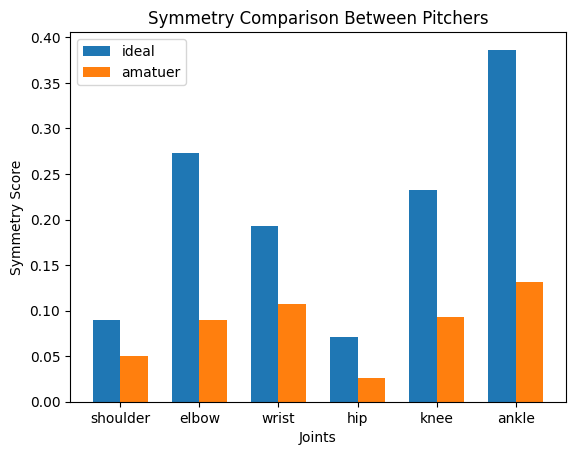

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 관절 인덱스 설정
joint_indices = {
    'shoulder': [0, 1],
    'elbow': [2, 3],
    'wrist': [4, 5],
    'hip': [6, 7],
    'knee': [8, 9],
    'ankle': [10, 11],
}

# 대칭성을 계산하는 함수
def calculate_symmetry(data, joint_indices):
    symmetry_scores = {}
    for joint, (right_idx, left_idx) in joint_indices.items():
        # 오른쪽과 왼쪽 데이터 추출
        right_data = data[:, right_idx * 2:(right_idx * 2) + 2]
        left_data = data[:, left_idx * 2:(left_idx * 2) + 2]

        # 대칭성 점수 계산: 오른쪽과 왼쪽 데이터 간의 차이의 절대값을 취하고 평균을 계산
        symmetry = np.mean(np.abs(right_data - left_data), axis=0)
        symmetry_scores[joint] = np.mean(symmetry)
    
    return symmetry_scores

# 대칭성 점수를 시각화하는 함수
def plot_symmetry_comparison(symmetry_scores, pitcher_names):
    fig, ax = plt.subplots()
    bar_width = 0.35
    index = np.arange(len(joint_indices))

    for i, pitcher in enumerate(pitcher_names):
        scores = [symmetry_scores[pitcher][joint] for joint in joint_indices]
        ax.bar(index + i * bar_width, scores, bar_width, label=pitcher)

    ax.set_xlabel('Joints')
    ax.set_ylabel('Symmetry Score')
    ax.set_title('Symmetry Comparison Between Pitchers')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(list(joint_indices.keys()))
    ax.legend()
    
    plt.show()

# 데이터 파일 경로 설정
pitcher_files = {
    'ideal': os.path.expanduser("~/Documents/ds_study/mlb pitcher/ideal_pitcher_data.csv"),
    'amatuer': os.path.expanduser("~/Documents/ds_study/mlb pitcher/amatuer.csv"),
}
# 대칭성 분석 및 시각화 수행
symmetry_scores = {}
for pitcher_name, file_path in pitcher_files.items():
    # CSV 파일에서 데이터 로드
    data = np.loadtxt(file_path, delimiter=',')
    
    # 대칭성 계산
    symmetry_scores[pitcher_name] = calculate_symmetry(data, joint_indices)

# 대칭성 비교 시각화
plot_symmetry_comparison(symmetry_scores, list(pitcher_files.keys()))